- 定义超参数
- 创建环境或模拟器
- 设计策略网络和价值模型
- 创建回放缓冲区和数据加载器
- 运行训练循环并分析结果




In [20]:
from collections import defaultdict  # 返回缺失键的默认值
import matplotlib.pyplot as plt  # 提供类似 MATLAB 的绘图框架
import torch  # PyTorch 的顶级包，一个深度学习框架
# PyTorch 模块的基类，使用 tensordict.TensorDict 作为输入和输出
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor  # 从输入张量中提取正态分布的参数
from torch import nn  # PyTorch 的子包，提供用于构建神经网络的模块和类
from torchrl.collectors import SyncDataCollector  # 使用 actor 模块从多个环境中同步收集数据的类
from torchrl.data.replay_buffers import ReplayBuffer  # 存储从环境中收集的数据并允许进行训练采样的类
# 从重放缓冲存储器中无放回地采样数据的类
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
# 将数据存储为内存中的张量并允许延迟访问它们的类
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,  # 将多个环境变换组合成一个变换的类
    DoubleToFloat,  # 将环境观察或动作空间中的双精度张量转换为单精度张量的类
    ObservationNorm,  # 使用平均值和标准差的运行统计信息对观察进行归一化的类
    StepCounter,  # 计算在环境中执行了多少步并将其添加到观察空间作为额外维度的类
    TransformedEnv,  # 对观察、动作、奖励或完成标志应用变换的环境抽象基类
)
from torchrl.envs.libs.gym import GymEnv  # 实现了 torchrl.envs.Env 接口的 gym 环境包装器类
# 检查环境是否符合预期规范并设置支持探索模式（如随机 vs 确定性动作）的函数
from torchrl.envs.utils import check_env_specs, set_exploration_mode
# 根据观察输出动作概率分布的 actor（策略网络）类
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss  # 实现策略梯度方法中近端策略优化（PPO）损失函数剪裁版本的类
from torchrl.objectives.value import GAE  # 计算策略梯度方法中广义优势估计（GAE）信号的类
from tqdm import tqdm  # 提供循环和迭代器进度条


In [2]:
device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0


In [3]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000 // frame_skip


In [4]:
# cardinality of the sub-samples gathered from the current data in the inner loop
sub_batch_size = 64
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    # clip value for PPO loss: see the equation in the intro for more context.
    0.2
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4


In [5]:
base_env = GymEnv("InvertedDoublePendulum-v4",
                  device=device, frame_skip=frame_skip)


In [6]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)


In [7]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)


In [8]:
print("normalization constant shape:", env.transform[0].loc.shape)


normalization constant shape: torch.Size([11])


In [9]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)


observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int64, domain=continuous), device=cpu, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BoundedTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1])

In [10]:
check_env_specs(env)


check_env_specs succeeded!


In [14]:
rollout = env.rollout(6)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)


rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([5, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([5]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([5, 11]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.flo

In [15]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)


c:\Users\Yuming\Documents\ResMan\man\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)


In [18]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)


In [21]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)


c:\Users\Yuming\Documents\ResMan\man\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))


Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.

In [23]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)


In [24]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)


c:\Users\Yuming\Documents\ResMan\man\lib\site-packages\torchrl\data\replay_buffers\replay_buffers.py:151: UserWarning: Constructing replay buffer without specifying behaviour is no longer recommended, and will be deprecated in the future.
  warnings.warn(


In [25]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)


In [26]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata, *_ = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(
                eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(
                eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(
        ", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\Yuming\Documents\ResMan\man\lib\site-packages\torchrl\data\replay_buffers\replay_buffers.py:274: UserWarning: batch_size argument in sample has been deprecated. Set the batch_size when constructing the replay buffer instead.
  warnings.warn(
eval cumulative reward:  175.8411 (init:  110.6849), eval step-count: 18, average reward= 9.2582 (init= 9.0855), step count (max): 44, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:10<00:00, 167.48it/s]

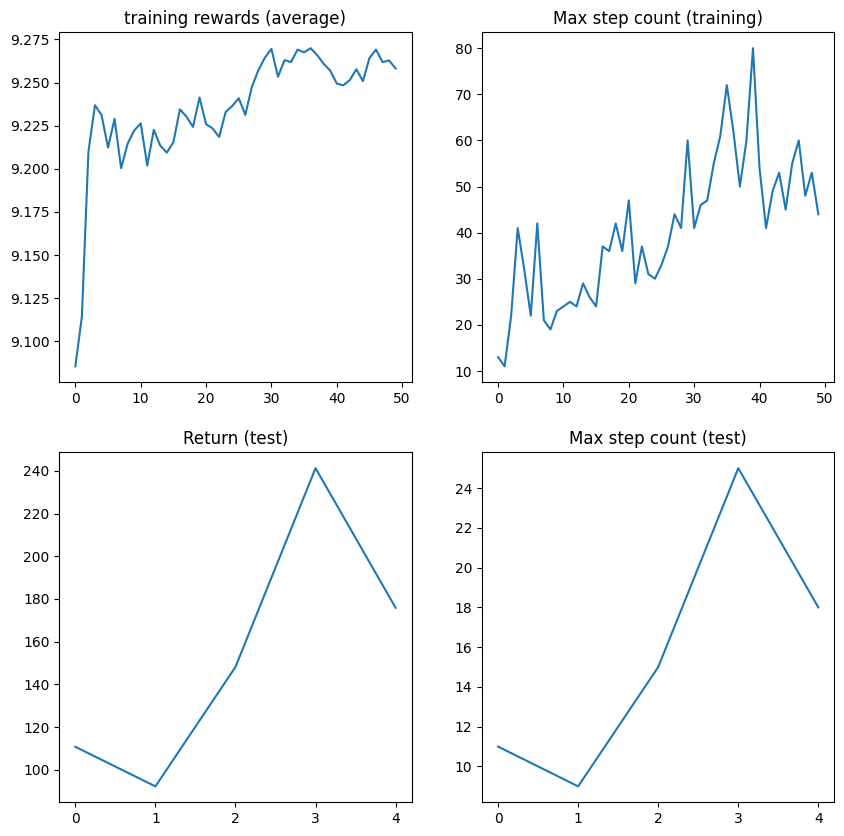

eval cumulative reward:  175.8411 (init:  110.6849), eval step-count: 18, average reward= 9.2582 (init= 9.0855), step count (max): 44, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:20<00:00, 167.48it/s]

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()
